# 1: Introduction

In this notebook, we demonstrate how to fit a time correlation function (TCF) with both real and imaginary parts using a set of damped cosine functions. The correlation function originates from a Debye-Lorentz type spectral density with parameters such as the reorganization energy, thermal energy, and a relaxation rate. We will use `scipy.optimize.curve_fit` to fit these functions and then compare the fitted results to the summed TCF.


In [23]:
# 1. Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator

# Matplotlib settings (optional)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

C:\Users\User\AppData\Local\Temp\ipykernel_3700\1266659742.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# 2. Define Parameters
Below, we specify all the relevant physical parameters for our problem:

- $hbar$: Planck's constant (in certain units).

- $gamma$: Bath relaxation rate.

- $l$: Reorganization energy.

- $kT$: Thermal energy.

- $beta$: Inverse temperature.

- $N$: Number of effective oscillators in the fit.

- $n\_matsubara\_term$: Number of Matsubara terms.

- $init\_guess$: Initial guess value for the fitting parameters.

In [24]:
# 2. Bath parameters
hbar = 5308 # (cm^-1 * fs)
gamma = 53.08 / hbar         # bath relaxation rate (fs^-1)
l = 60 / hbar                # reorganization energy (fs^-1)
kt = 0.5 * gamma             # thermal energy (fs^-1)
beta = 1 / kt                # inverse temperature (fs)
N = 3                        # number of effective oscillators
n_matsubara_term = 99
init_guess = 0.001

# 3. Define Original Correlation Functions

Here, we define the real and imaginary parts of the TCF $C(t)$.

- `original_function_real(t)` computes the real part of $C(t)$.

- `original_function_real(t)` computes the real part of $C(t)$.

In [ ]:
# 3. Define the real and imaginary parts of the TCF

def original_function_real(t):
    """
    Computes the real part of the TCF for the specified bath parameters (e.g., gamma, l, beta, hbar, etc.).
    
    Example of the calculation:
    1. Initial term: gamma * l / tan(beta * hbar * gamma / 2) * exp(-gamma * t)
    2. Summation over Matsubara frequencies:
       g = 2 * pi * (i+1) / (beta * hbar)
       c = 4 * l * gamma / (beta * hbar) * g / (g^2 - gamma^2)
       res += c * exp(-g * t)

    Parameters
    ----------
    t : float
        Time variable.
    
    Returns
    ----------
    float
        The real part of the TCF evaluated at time t.
    """
    res = gamma * l / np.tan(beta * hbar * gamma / 2) * np.exp(-gamma * t)
    for i in range(n_matsubara_term):
        g = 2 * np.pi * (i + 1) / (beta * hbar)
        c = 4 * l * gamma / (beta * hbar) * g / (g**2 - gamma**2)
        res += c * np.exp(-g * t)
    return res

def original_function_imag(t):
    """
    Imaginary part of the Time Correlation Function (TCF).
    In this example, it is computed as:
    
    gamma * l * exp(-gamma * t)
    
    Parameters
    ----------
    t : float
        Time variable.

    Returns
    ----------
    float
        The imaginary part of the TCF evaluated at time t.
    """
    return gamma * l * np.exp(-gamma * t)

# 4. Define Fitting Functions

We want to fit both the real and imaginary parts of the TCF to a sum of damped cosines called **effective thermal oscillator model (ETOM)**:
$$
    Re\{C_{eff}(t)\} = \sum_{j}^{N} a_j\cos(w_jt)e^{-g_jt}, \\
    Im\{C_{eff}(t)\} = \sum_{j}^{N} b_j\cos(w_jt)e^{-g_jt}. \\
$$
- For the real part, we will fit parameters $(a_j, w_j, g_j)$.

- For the imaginary part, we will reuse $(w_j, g_j)$ from the real-part fit, but fit different amplitudes $(b_j)$.


In [26]:
# 4. Define the fitting functions

def fit_function_real(t, *params):
    """
    Fitting function for the real part of the correlation function.
    We use a sum of N damped cosines:
        sum_{i=1 to N} [a_i cos(w_i t) exp(-g_i t)]
    
    params is expected to contain 3*N parameters in the order:
    (a_0, g_0, w_0, a_1, g_1, w_1, ..., a_(N-1), g_(N-1), w_(N-1)).
    """
    result = 0.0
    for j in range(N):
        a = params[3 * j]
        g = params[3 * j + 1]
        w = params[3 * j + 2]
        result += a * np.cos(w * t) * np.exp(-g * t)
    return result

def fit_function_imag(t, *params):
    """
    Fitting function for the imaginary part of the correlation function.
    We reuse (g, w) from the real part fit and only fit b_i for amplitude:
        sum_{i=1 to N} [b_i cos(w_i t) exp(-g_i t)]
    
    params is expected to contain N parameters (b_0, b_1, ..., b_(N-1)).
    g_values and w_values are taken from the real part fit.
    """
    result = 0.0
    for j in range(N):
        b = params[j]
        g = g_values[j]
        w = w_values[j]
        result += b * np.cos(w * t) * np.exp(-g * t)
    return result

# 5. Generate Data and Perform the Fit

- We create a time grid `t_values`.

- We compute the real and imaginary parts of the TCF `(y_values_real, y_values_imag)`.

- We perform two separate fits:
    1. Fit the real part to `fit_function_real`, obtaining $(a_j, w_j, g_j)$.
    
    2. Fit the imaginary part to `fit_function_imag`, but only fitting $(b_j)$ since $(w_j, g_j)$ are taken from the real-part fit.

In [27]:
# 5. Generate data points
t_values = np.linspace(0, 1000, 1000)
y_values_real = np.array([original_function_real(t) for t in t_values])
y_values_imag = np.array([original_function_imag(t) for t in t_values])

# 6. Perform the fit for the real part
initial_guess_real = [init_guess, init_guess, init_guess] * N  # (a_0, g_0, w_0, ..., a_(N-1), g_(N-1), w_(N-1))
popt_real, pcov_real = curve_fit(
    fit_function_real, t_values, y_values_real,
    p0=initial_guess_real, maxfev=1_000_000_000
)

# Extract (g_i, w_i) from the real-part fit
g_values = popt_real[1::3]  # every 3rd element, starting from index 1
w_values = popt_real[2::3]  # every 3rd element, starting from index 2

# 7. Perform the fit for the imaginary part
initial_guess_imag = [init_guess] * N
popt_imag, pcov_imag = curve_fit(
    fit_function_imag, t_values, y_values_imag,
    p0=initial_guess_imag, maxfev=1_000_000_000
)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# 6. Print Fitting Results

To do the further HEOM calculations, we have to split the cosine part of the ETOM into exponential format, that is, ETOM can be expressed as:
$$
\begin{align}
    C_{eff}(t) &= \sum_{j}^{N} (a_j + b_ji)\cos(w_jt)e^{-g_jt} \\
               &= \sum_{j}^{N} \frac{a_j + b_ji}{2}(e^{-(g_j - iw_j)t} + e^{-(g_j + iw_j)t}).
\end{align}
$$ 
Here we can print the parameters in a form that collects them in pairs of amplitudes $(a_j, b_j)$ and frequencies $(w_j, g_j)$.

In [28]:
# 8. Print out the fit parameters
for j in range(N):
    a = popt_real[3 * j]
    b = popt_imag[j]
    g = popt_real[3 * j + 1]
    w = popt_real[3 * j + 2]
    
    # Print pairs for positive and negative frequencies
    print(f"{a / 2:.8f} {b / 2:.8f} {g:.8f} {w:.8f}")
    print(f"{a / 2:.8f} {b / 2:.8f} {g:.8f} {-w:.8f}")

-0.00000234 -0.00000000 0.00035860 0.00000000
-0.00000234 -0.00000000 0.00035860 -0.00000000
-0.00001620 0.00005652 0.01000000 0.00000083
-0.00001620 0.00005652 0.01000000 -0.00000083
0.00000228 0.00000000 0.00035767 0.00002357
0.00000228 0.00000000 0.00035767 -0.00002357


# 7. Plot Results

Below, we visualize both the real and imaginary parts of the TCF, comparing the summed results to the fitted results.

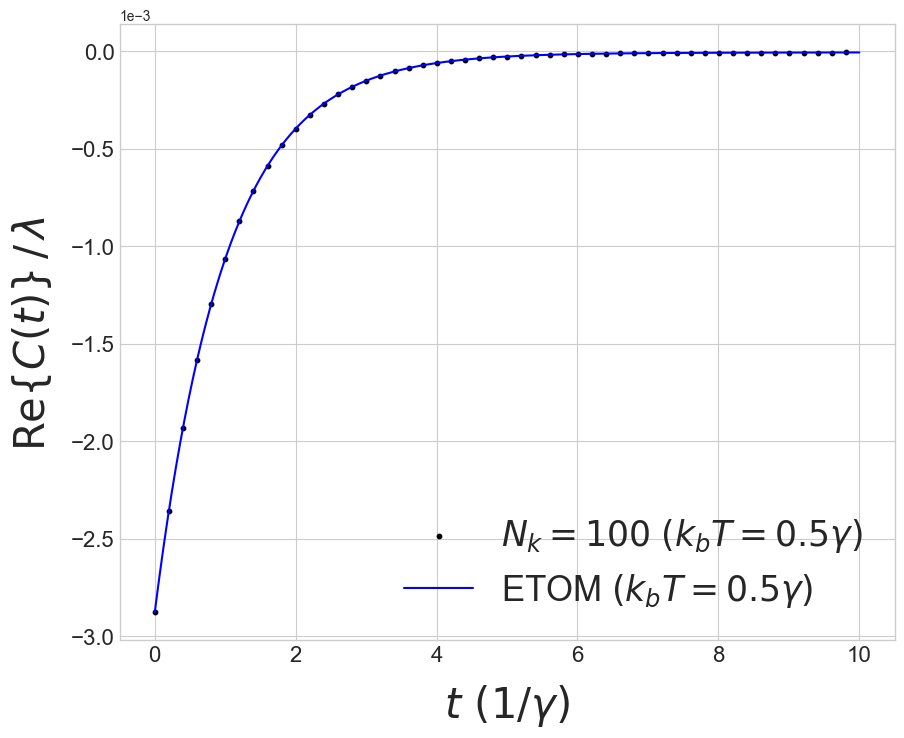

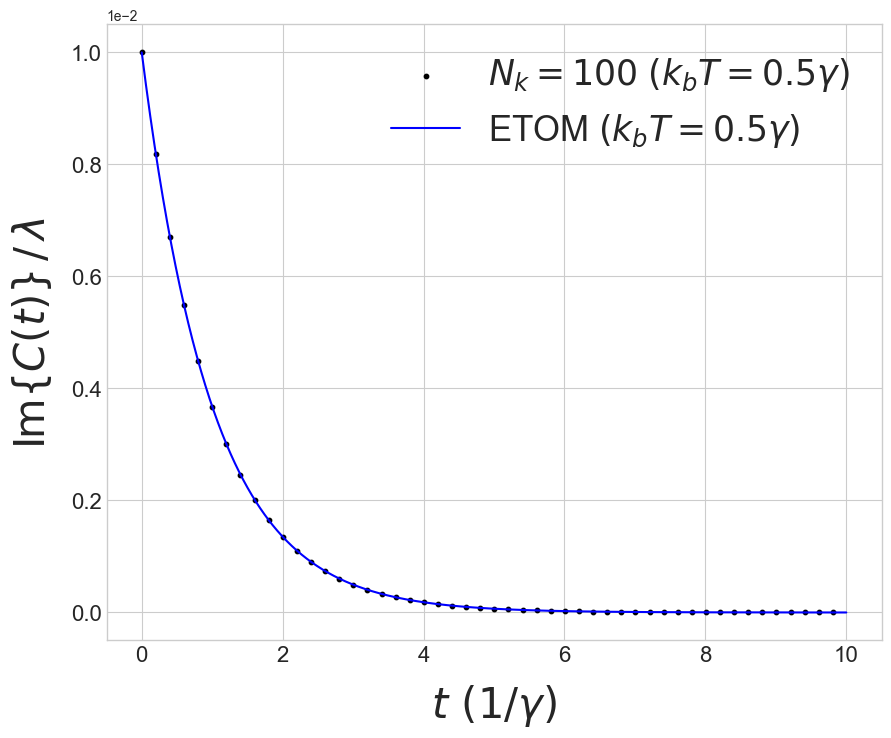

In [29]:
# 9. Plot settings
fontsize = 30
labelpad = 12
labelsize = 16

# Plot the Real Part
plt.figure(figsize=(10, 8))
plt.scatter(
    t_values[::20] * gamma,
    y_values_real[::20] / l,
    label=r'$N_k = 100$ $(k_bT = 0.5\gamma)$',
    s=10, color='black'
)
plt.plot(
    t_values * gamma,
    fit_function_real(t_values, *popt_real) / l,
    label=r'ETOM $(k_bT = 0.5\gamma)$',
    color='blue'
)
plt.xlabel(r"$t\ (1 / \gamma)$", fontsize=fontsize, labelpad=labelpad)
plt.ylabel(r"$\mathrm{Re}\{C(t)\}\,/\,\lambda$", fontsize=fontsize, labelpad=labelpad)
plt.legend(fontsize=fontsize - 5)
plt.tick_params(axis='both', which='major', labelsize=labelsize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()

# Plot the Imaginary Part
plt.figure(figsize=(10, 8))
plt.scatter(
    t_values[::20] * gamma,
    y_values_imag[::20] / l,
    label=r'$N_k = 100$ $(k_bT = 0.5\gamma)$',
    s=10, color='black'
)
plt.plot(
    t_values * gamma,
    fit_function_imag(t_values, *popt_imag) / l,
    label=r'ETOM $(k_bT = 0.5\gamma)$',
    color='blue'
)
plt.xlabel(r"$t\ (1 / \gamma)$", fontsize=fontsize, labelpad=labelpad)
plt.ylabel(r"$\mathrm{Im}\{C(t)\}\,/\,\lambda$", fontsize=fontsize, labelpad=labelpad)
plt.legend(fontsize=fontsize - 5)
plt.tick_params(axis='both', which='major', labelsize=labelsize)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


# Step 10: Insert Fit Results into `key.key`

In this step, we will:

1. Read the file at `../2d_input/key.key`.

2. Find the line containing the keyword `BATH` and the line containing the keyword `DIPOLE`.

3. Remove all content between `BATH` and `DIPOLE`.

5. Insert our fit results.


In [ ]:
import os

# Assume we already have:
#   l: float, the reorganization energy 
#   N: int, the number of effective oscillators
#   popt_real: array from curve_fit (includes a_j, g_j, w_j for each oscillator)
#   popt_imag: array from curve_fit (includes b_j for each oscillator)

# 1) Prepare the lines to be inserted
new_data_lines = []

# First line: reorganization energy
new_data_lines.append(f"{l}\n")

# Second line: number of ETOM modes
new_data_lines.append(f"{2 * N}\n")

# Next pairs of lines:
#   (a/2) (b/2) g w
#   (a/2) (b/2) g -w
for j in range(N):
    a = popt_real[3 * j]
    b = popt_imag[j]
    g = popt_real[3 * j + 1]
    w = popt_real[3 * j + 2]

    new_data_lines.append(f"{a / 2:.8f} {b / 2:.8f} {g:.8f} {w:.8f}\n")
    new_data_lines.append(f"{a / 2:.8f} {b / 2:.8f} {g:.8f} {-w:.8f}\n")

# 2) Read the existing file
key_file_path = "../2d_input/key.key"
with open(key_file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

# 3) Locate the lines containing BATH and DIPOLE
bath_index = None
dipole_index = None

for i, line in enumerate(lines):
    content = line.strip()
    if content == "BATH" and bath_index is None:
        bath_index = i
    elif content == "DIPOLE" and dipole_index is None:
        dipole_index = i

# Check if we found both keywords and if BATH appears before DIPOLE
if bath_index is None or dipole_index is None or bath_index >= dipole_index:
    print("Error: Could not find correct BATH and DIPOLE order in the file.")
else:
    # 4) Remove everything between BATH and DIPOLE and insert new data
    
    # Keep lines from the start of the file up to BATH (including BATH)
    updated_lines = lines[:bath_index+1]
    
    # Insert our new data lines
    updated_lines.extend(new_data_lines)
    updated_lines.append("\n")
    
    # Keep DIPOLE and everything after it
    updated_lines.append(lines[dipole_index])
    updated_lines.extend(lines[dipole_index+1:])
    
    # 5) Write back to the file
    with open(key_file_path, "w") as f:
        f.writelines(updated_lines)
    
    print("Successfully updated key.key! Content between BATH and DIPOLE removed, and new data inserted.")

# 11. Version Information

Below we print out the versions of Python and the main libraries used in this notebook for reproducibility purposes:

In [31]:
import sys
import numpy as np
import scipy
import matplotlib

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("SciPy version:", scipy.__version__)
print("Matplotlib version:", matplotlib.__version__)

Python version: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
NumPy version: 1.24.3
SciPy version: 1.11.1
Matplotlib version: 3.7.1
